В очень крупной компании по доставке пиццы ведется работа над приложением для курьеров.

Есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены доставка очень сильно проседает в эффективности. 

Data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Было решено раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Исходные данные включают разбивку на тестовую и контрольные выборки.  
<b>Задача</b> – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.


#### Описание данных
- <b>order_id</b> - id заказа
- <b>delivery_time</b> - время доставки в минутах
- <b>district</b> - район доставки
- <b>experiment_group</b> - экспериментальная группа

Для начала сформулируем гипотезы для проверки.  
Нулевая гипотеза <b>(H0)</b>: Разницы между средним временем доставки в тестовой и контрольной группе нет.  
Альтернативная гипотеза <b>(H1)</b>: Разница между средним временем доставки в тестовой и контрольной группе есть.

In [15]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('experiment_lesson_4.csv')

In [3]:
df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.2+ KB


In [5]:
df.nunique()

order_id            20196
delivery_time          72
district                3
experiment_group        2
dtype: int64

Сопоставим графики распределения и экспериментальные группы:

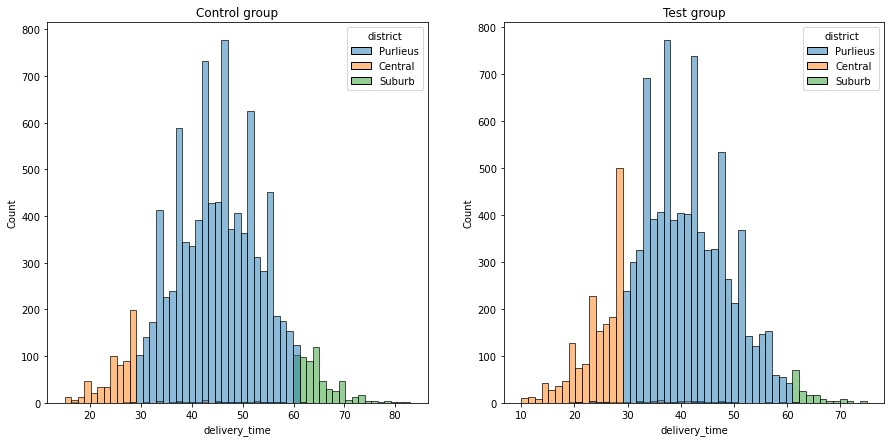

In [6]:
fig, ax =plt.subplots(1, 2, figsize=(15,7))
sns.histplot(data=df.query('experiment_group=="control"'),
             x='delivery_time', 
             hue='district',
            ax=ax[0]).set_title("Control group");
sns.histplot(data=df.query('experiment_group=="test"'),
             x='delivery_time', 
             hue='district',
            ax=ax[1]).set_title("Test group");

Посчитаем количество наблюдений в тестовой и контрольной группе. На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [7]:
print(' Количество наблюдений в тестовой выборке: ', df.query('experiment_group=="test"').shape[0], '\n', \
      'Количество наблюдений в контрольной выборке: ', df.query('experiment_group=="control"').shape[0], '\n',\
      'Разница -', df.query('experiment_group=="test"').shape[0] - df.query('experiment_group=="control"').shape[0], \
      'наблюдений')

 Количество наблюдений в тестовой выборке:  10104 
 Количество наблюдений в контрольной выборке:  10092 
 Разница - 12 наблюдений


Изучим распределения. Проверим выполнение условий на нормальность с помощью теста Шапиро-Уилка и посчитаем стандартное отклонение в тестовой и контрольной выборках.

Перед применением критерия при проверке на нормальность (и для теста, и для контроля) необходимо сделать семплирование, так как на больших выборках можно получить неверные результаты.

Чувствительность любого теста зависит от размера выборки. Это касается и теста Шапиро-Уилка - на больших выборках он детектирует даже самые незначительные отклонения от нормальности. Поэтому мы берём случайные 1000 значений из выборки, чтобы обойти этот недостаток.

Есть шанс, что случайные 1000 значений всё же сформируют ненормальное распределение, поэтому в задаче рекомендуется использовать аргумент `random_state=17` для стабильности и воспроизводимости результатов.

In [8]:
# сэмплируем тестовую и контрольные выборки
test_sample = df[df['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17)
control_sample = df[df['experiment_group'] == 'control']['delivery_time'].sample(1000, random_state=17)

In [9]:
stats.shapiro(test_sample)

ShapiroResult(statistic=0.9975475668907166, pvalue=0.14005419611930847)

In [10]:
stats.shapiro(control_sample)

ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)

In [11]:
df.query('experiment_group=="test"').delivery_time.std()

9.883308351129031

In [12]:
df.query('experiment_group=="control"').delivery_time.std()

9.990016960247171

Итак, для того, чтобы проверить нормальность распределения, я использовала тест Шапиро-Уилка. Нулевая гипотеза которого заключается в том, что тестируемое распределение нормально.
Тест показал, что значения в тестовой и контрольной группах распределены нормально (p-value>0.05).  
Стандартное отклонение времени доставки в тесте равно 9.88.  
Стандартное отклонение времени доставки в контроле равно 9.99.

In [16]:
stats.levene(df.query('experiment_group=="test"').delivery_time,
             df.query('experiment_group=="control"').delivery_time)

LeveneResult(statistic=0.2702281101900882, pvalue=0.6031844931083392)

С помощью критерия Левена проверено удовлетворение требованию гомогенности дисперсий. P-value > 0.05, значит, дисперсии тестовой и контрольной выборок приблизительно равны.

Сравним средние в тестовой и контрольной выборках (на полных, несемплированных данных) с помощью t-критерия Стьюдента.
Для применения данного критерия необходимо, чтобы исходные данные имели нормальное распределение и было соблюдено требование гомогенности дисперсий. Только что это было проверено.

In [13]:
stats.ttest_ind(df.query('experiment_group=="test"').delivery_time, df.query('experiment_group=="control"').delivery_time)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

Р-value < 0.05, значит, мы отклоняем нулевую гипотеру о равенстве средних в тестовой и контрольной выборках. То есть тестовая и контрольные выборки не принадлежат одной генеральной совокупности. Различия статистически значимы.

Посчитаем, на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной. 

In [14]:
(df.query('experiment_group=="test"').delivery_time.mean() / df.query('experiment_group=="control"').delivery_time.mean() - 1) * 100

-13.354653121660808

Среднее время доставки в тестовой группе уменьшилось на 13,35 минут. Достигнутый результат статистически значим.  
<b>Вывод</b>: применяем новый алгоритм ко всем клиентам, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле на 13,35 минут.